In [1]:
from pathlib import Path
from IPython.display import HTML, display
css = Path("../../../css/custom.css").read_text(encoding="utf-8")
display(HTML(f"<style>{css}</style>"))

# Chapter 2 — Basics of Data and Preprocessing
## Lesson 10: Imputation Methods (Simple, kNN, Iterative/Multiple Imputation Concepts)

Missing values are not just a nuisance. They change the effective data-generating process seen by your model, bias estimates, increase variance, and can create failure modes in deployment when “rare but meaningful” cases are systematically incomplete.

This lesson builds a practitioner-grade mental model for imputation, and then translates that model into reproducible Python workflows with scikit-learn pipelines. We will work with multiple repository datasets (classification and regression) and evaluate how imputation choices change downstream model performance.

**What you will be able to do after this lesson**
- Diagnose missingness patterns and quantify missingness per feature and per row.
- Implement baseline (simple) imputation correctly without leakage.
- Use $k$-Nearest Neighbors imputation and understand when it fails (scaling, high dimension, sparsity).
- Use iterative/chained-equations imputation and connect it to “multiple imputation” ideas.
- Evaluate imputation strategies using end-to-end modeling metrics, not only “how many NaNs remain”.
- Build column-wise preprocessing pipelines for mixed numeric/categorical data.


## 1. Setup and data loading

We will use multiple datasets in this repository to demonstrate different types of missing-data challenges:

- **Diabetes** (tabular numeric + target): good for numeric imputation and classification evaluation.
- **House prices** (mixed types + target): good for mixed-type pipelines.
- **Diamonds** (mixed types + target): good for iterative imputation and regression evaluation.
- **Drug200** (categorical-heavy): good for categorical imputation and encoding.

The file paths below follow your repository structure; the notebook assumes it is located at:
`Tutorials/English/Chapter2/Chapter2_Lesson10.ipynb`.


In [2]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer

from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 50)
np.random.seed(42)

In [3]:
# Load several datasets
diabetes_path = "../../../Datasets/Classification/diabetes.csv"
house_path    = "../../../Datasets/Regression/house-prices.csv"
diamonds_path = "../../../Datasets/Regression/diamonds.csv"
drug_path     = "../../../Datasets/Classification/drug200.csv"

diabetes = pd.read_csv(diabetes_path)
house    = pd.read_csv(house_path)
diamonds = pd.read_csv(diamonds_path)
drug     = pd.read_csv(drug_path)

print("diabetes:", diabetes.shape)
print("house:", house.shape)
print("diamonds:", diamonds.shape)
print("drug:", drug.shape)

display(diabetes.head())
display(house.head())
display(diamonds.head())
display(drug.head())

diabetes: (768, 9)
house: (128, 8)
diamonds: (53940, 11)
drug: (200, 6)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,classification
0,6,148,72,35,0,33.6,0.627,50,Diabetic
1,1,85,66,29,0,26.6,0.351,31,Non-Diabetic
2,8,183,64,0,0,23.3,0.672,32,Diabetic
3,1,89,66,23,94,28.1,0.167,21,Non-Diabetic
4,0,137,40,35,168,43.1,2.288,33,Diabetic


,Home,Price,SqFt,Bedrooms,Bathrooms,Offers,Brick,Neighborhood
0,1,114300,1790,2,2,2,No,East
1,2,114200,2030,4,2,3,No,East
2,3,114800,1740,3,2,1,No,East
3,4,94700,1980,3,2,3,No,East
4,5,119800,2130,3,3,3,No,East


,id,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY


## 2. Missingness diagnostics: quantify before you “fix”

A common anti-pattern is to jump directly to an imputer without first understanding:
- **How much** is missing (per feature and per row).
- **Where** missingness concentrates (subpopulations, time, geography, data sources).
- **Whether** missingness correlates with the target (a warning sign for MNAR and selection effects).

### 2.1. Counting missing values

Let $X \in \mathbb{R}^{n \times d}$ be your feature matrix. Define an indicator matrix $M \in \{0,1\}^{n \times d}$ where:
$$
M_{ij} = \begin{cases}
1 & \text{if } X_{ij} \text{ is missing} \\
0 & \text{otherwise.}
\end{cases}
$$
Then:
- Feature-wise missingness rate: $r_j = \frac{1}{n} \sum_{i=1}^n M_{ij}$
- Row-wise missingness rate: $q_i = \frac{1}{d} \sum_{j=1}^d M_{ij}$


,missing_count,missing_rate
Pregnancies,0,0.0
Glucose,0,0.0
BloodPressure,0,0.0
SkinThickness,0,0.0
Insulin,0,0.0
BMI,0,0.0
DiabetesPedigreeFunction,0,0.0
Age,0,0.0
classification,0,0.0


,missing_count,missing_rate
Home,0,0.0
Price,0,0.0
SqFt,0,0.0
Bedrooms,0,0.0
Bathrooms,0,0.0
Offers,0,0.0
Brick,0,0.0
Neighborhood,0,0.0


,missing_count,missing_rate
id,0,0.0
carat,0,0.0
cut,0,0.0
color,0,0.0
clarity,0,0.0
depth,0,0.0
table,0,0.0
price,0,0.0
x,0,0.0
y,0,0.0


,missing_count,missing_rate
Age,0,0.0
Sex,0,0.0
BP,0,0.0
Cholesterol,0,0.0
Na_to_K,0,0.0
Drug,0,0.0


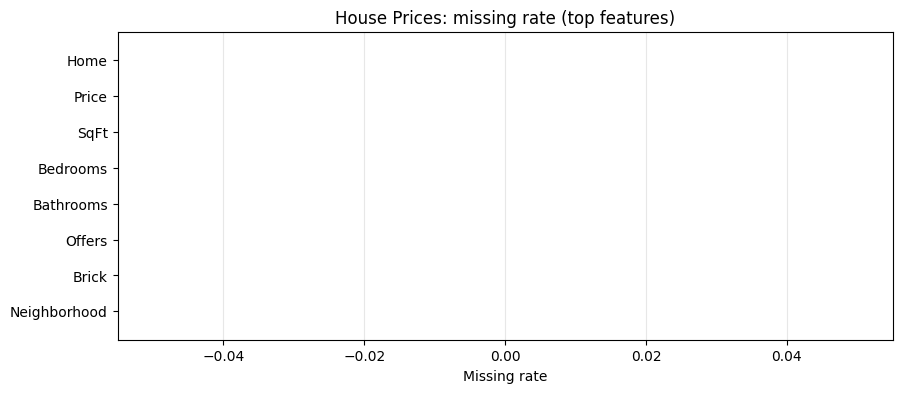

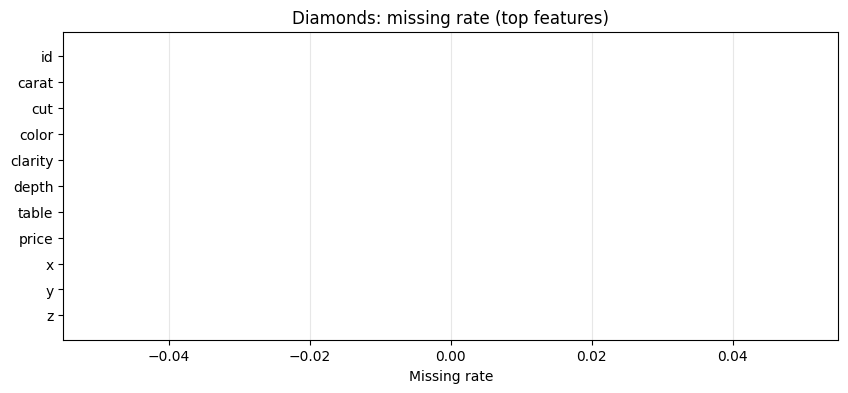

In [4]:
def missing_summary(df: pd.DataFrame) -> pd.DataFrame:
    out = pd.DataFrame({
        "missing_count": df.isna().sum(),
        "missing_rate": df.isna().mean()
    }).sort_values("missing_rate", ascending=False)
    return out

def plot_missing_rate(summary: pd.DataFrame, title: str, top_k: int = 25):
    s = summary.head(top_k).iloc[::-1]
    plt.figure(figsize=(10, max(4, 0.3 * len(s))))
    plt.barh(s.index.astype(str), s["missing_rate"])
    plt.xlabel("Missing rate")
    plt.title(title)
    plt.grid(True, axis="x", alpha=0.3)
    plt.show()

ms_house    = missing_summary(house)
ms_diamonds = missing_summary(diamonds)

display(missing_summary(diabetes))
display(ms_house.head(15))
display(ms_diamonds.head(15))
display(missing_summary(drug))

plot_missing_rate(ms_house, "House Prices: missing rate (top features)")
plot_missing_rate(ms_diamonds, "Diamonds: missing rate (top features)")


### 2.2. Controlled missingness for experiments

We inject missingness in a controlled way to compare imputers fairly. Key rule for supervised learning: **do not corrupt the target**.


In [5]:
def inject_missingness(
    df: pd.DataFrame,
    cols,
    frac: float = 0.1,
    pattern: str = "mcar",
    seed: int = 0
) -> pd.DataFrame:
    rng = np.random.default_rng(seed)
    out = df.copy()
    n = len(out)
    cols = list(cols)

    if pattern == "mcar":
        for c in cols:
            mask = rng.random(n) < frac
            out.loc[mask, c] = np.nan

    elif pattern == "row_dependent":
        proxy = out[cols[0]].astype(float)
        z = (proxy - np.nanmean(proxy)) / (np.nanstd(proxy) + 1e-12)
        p = 1 / (1 + np.exp(-z))
        p = np.clip(frac * 0.5 + p * frac, 0, 0.95)
        for c in cols:
            mask = rng.random(n) < p
            out.loc[mask, c] = np.nan

    elif pattern == "block":
        mask_rows = rng.random(n) < frac
        out.loc[mask_rows, cols] = np.nan

    else:
        raise ValueError("pattern must be one of: mcar, row_dependent, block")

    return out

# Diabetes: inject in features only
diabetes_num_cols = [c for c in diabetes.columns if c != "classification"]
diabetes_miss = inject_missingness(diabetes, cols=diabetes_num_cols[:5], frac=0.15, pattern="mcar", seed=1)

# House: inject in features only (Price stays intact)
house_miss = inject_missingness(house, cols=["SqFt", "Offers"], frac=0.12, pattern="row_dependent", seed=2)

# Diamonds: inject in features only (price stays intact)
diamonds_miss = inject_missingness(diamonds, cols=["carat", "depth", "table", "x", "y", "z"], frac=0.10, pattern="block", seed=3)

display(missing_summary(diabetes_miss).head(10))
display(missing_summary(house_miss).head(10))
display(missing_summary(diamonds_miss).head(10))


,missing_count,missing_rate
SkinThickness,132,0.171875
Insulin,121,0.157552
BloodPressure,118,0.153646
Glucose,114,0.148438
Pregnancies,108,0.140625
BMI,0,0.000000
DiabetesPedigreeFunction,0,0.000000
Age,0,0.000000
classification,0,0.000000


,missing_count,missing_rate
SqFt,17,0.132812
Offers,12,0.093750
Price,0,0.000000
Home,0,0.000000
Bedrooms,0,0.000000
Bathrooms,0,0.000000
Brick,0,0.000000
Neighborhood,0,0.000000


,missing_count,missing_rate
carat,5568,0.103226
depth,5568,0.103226
table,5568,0.103226
z,5568,0.103226
x,5568,0.103226
y,5568,0.103226
id,0,0.000000
cut,0,0.000000
clarity,0,0.000000
color,0,0.000000


## 3. Simple imputation (baseline): mean/median/mode + pipelines

Imputation must be estimated on training folds only; a pipeline ensures that.


In [6]:
# Diabetes classification
X = diabetes_miss.drop(columns=["classification"])
y = diabetes_miss["classification"]

pipe_mean = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(max_iter=2000))
])

pipe_median = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(max_iter=2000))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
acc_mean = cross_val_score(pipe_mean, X, y, cv=cv, scoring="accuracy")
acc_median = cross_val_score(pipe_median, X, y, cv=cv, scoring="accuracy")

print("Mean imputation accuracy:", acc_mean.mean(), "+/-", acc_mean.std())
print("Median imputation accuracy:", acc_median.mean(), "+/-", acc_median.std())


Mean imputation accuracy: 0.7603853662677192 +/- 0.03495755597544461
Median imputation accuracy: 0.7564977506153976 +/- 0.03340084129367913


### 3.1. Mixed-type pipeline (House prices)

We predict `Price` using:
- Numeric: median imputation + scaling
- Categorical: most-frequent imputation + one-hot


In [7]:
house_work = house_miss.copy()

target = "Price"
X_house = house_work.drop(columns=[target])
y_house = house_work[target]

# Defensive: supervised learning requires non-missing y
mask_y = y_house.notna()
X_house = X_house.loc[mask_y].copy()
y_house = y_house.loc[mask_y].copy()

num_cols = X_house.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X_house.columns if c not in num_cols]

numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, num_cols),
        ("cat", categorical_pipe, cat_cols)
    ],
    remainder="drop"
)

model = Pipeline(steps=[
    ("prep", preprocess),
    ("reg", Ridge(alpha=1.0))
])

cv_reg = KFold(n_splits=5, shuffle=True, random_state=42)
mae = -cross_val_score(model, X_house, y_house, cv=cv_reg, scoring="neg_mean_absolute_error")
rmse = np.sqrt(-cross_val_score(model, X_house, y_house, cv=cv_reg, scoring="neg_mean_squared_error"))

print("House prices baseline MAE:", mae.mean(), "+/-", mae.std())
print("House prices baseline RMSE:", rmse.mean(), "+/-", rmse.std())


House prices baseline MAE: 9022.071889342003 +/- 1604.2314587624026
House prices baseline RMSE: 11447.186876349419 +/- 1781.022369887846


## 4. kNN imputation

kNN fills missing values using neighbors in feature space. Because it relies on distances, scaling matters.


In [8]:
pipe_knn = Pipeline(steps=[
    ("imputer", KNNImputer(n_neighbors=7, weights="distance")),
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(max_iter=2000))
])

acc_knn = cross_val_score(pipe_knn, X, y, cv=cv, scoring="accuracy")
print("kNN imputation accuracy:", acc_knn.mean(), "+/-", acc_knn.std())

df_scores = pd.DataFrame({"mean": acc_mean, "median": acc_median, "knn": acc_knn})
display(df_scores.describe())


kNN imputation accuracy: 0.768177574059927 +/- 0.02293207730829278


,mean,median,knn
count,5.000000,5.000000,5.000000
mean,0.760385,0.756498,0.768178
std,0.039084,0.037343,0.025639
min,0.714286,0.707792,0.732026
25%,0.725490,0.725490,0.759740
50%,0.771242,0.777778,0.764706
75%,0.785714,0.779221,0.785714
max,0.805195,0.792208,0.798701


### 4.1. Two-stage variant: median → scale → kNN

A common trick: perform a simple imputation first so scaling can be computed, then apply kNN imputation.


In [9]:
pipe_two_stage = Pipeline(steps=[
    ("median", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("knn", KNNImputer(n_neighbors=7, weights="distance")),
    ("model", LogisticRegression(max_iter=2000))
])

acc_two_stage = cross_val_score(pipe_two_stage, X, y, cv=cv, scoring="accuracy")
print("Median->Scale->kNN accuracy:", acc_two_stage.mean(), "+/-", acc_two_stage.std())


Median->Scale->kNN accuracy: 0.7564977506153976 +/- 0.03340084129367913


## 5. Iterative imputation (chained equations)

Iterative imputation models each feature with missing values as a function of other features, looping until convergence.

We apply it on the diamonds dataset (regression) and compare two estimators for the imputer.


In [ ]:
from sklearn.experimental import enable_iterative_imputer  # noqa: F401
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

diamonds_work = diamonds_miss.copy()
if "id" in diamonds_work.columns:
    diamonds_work = diamonds_work.drop(columns=["id"])

target = "price"
X_dia = diamonds_work.drop(columns=[target])
y_dia = diamonds_work[target]

mask_y = y_dia.notna()
X_dia = X_dia.loc[mask_y].copy()
y_dia = y_dia.loc[mask_y].copy()

num_cols_dia = X_dia.select_dtypes(include=[np.number]).columns.tolist()
cat_cols_dia = [c for c in X_dia.columns if c not in num_cols_dia]

iter_linear = IterativeImputer(max_iter=15, random_state=42, sample_posterior=False)

rf_est = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1,
    min_samples_leaf=2
)
iter_rf = IterativeImputer(estimator=rf_est, max_iter=10, random_state=42, sample_posterior=False)

prep_linear = ColumnTransformer(
    transformers=[
        ("num", Pipeline([("imputer", iter_linear), ("scaler", StandardScaler())]), num_cols_dia),
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_cols_dia)
    ]
)

prep_rf = ColumnTransformer(
    transformers=[
        ("num", Pipeline([("imputer", iter_rf), ("scaler", StandardScaler())]), num_cols_dia),
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_cols_dia)
    ]
)

pipe_linear = Pipeline([("prep", prep_linear), ("reg", Ridge(alpha=1.0))])
pipe_rf = Pipeline([("prep", prep_rf), ("reg", Ridge(alpha=1.0))])

cv_reg = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_linear = np.sqrt(-cross_val_score(pipe_linear, X_dia, y_dia, cv=cv_reg, scoring="neg_mean_squared_error"))
rmse_rf = np.sqrt(-cross_val_score(pipe_rf, X_dia, y_dia, cv=cv_reg, scoring="neg_mean_squared_error"))

print("Diamonds RMSE IterativeImputer (default):", rmse_linear.mean(), "+/-", rmse_linear.std())
print("Diamonds RMSE IterativeImputer (RF estimator):", rmse_rf.mean(), "+/-", rmse_rf.std())


## 6. Multiple imputation concepts: repeated stochastic imputations

We approximate a multiple-imputation workflow by repeating stochastic iterative imputation and averaging predictions.

Steps:
1. Train/test split
2. For each of $M$ imputations: fit imputer on train, transform train/test, fit model, predict
3. Average predictions and inspect variability


In [ ]:
from sklearn.experimental import enable_iterative_imputer  # noqa: F401
from sklearn.impute import IterativeImputer

house_num = house_miss.select_dtypes(include=[np.number]).copy()
y = house_num["Price"].copy()
X = house_num.drop(columns=["Price"])

mask_y = y.notna()
X = X.loc[mask_y].copy()
y = y.loc[mask_y].copy()

idx = np.arange(len(X))
train_idx, test_idx = train_test_split(idx, test_size=0.25, random_state=42)

M = 5
preds = []

for m in range(M):
    imputer = IterativeImputer(max_iter=20, random_state=42 + m, sample_posterior=True)
    X_train = imputer.fit_transform(X.iloc[train_idx])
    X_test  = imputer.transform(X.iloc[test_idx])

    reg = Ridge(alpha=1.0)
    reg.fit(X_train, y.iloc[train_idx])
    preds.append(reg.predict(X_test))

preds = np.vstack(preds)

pred_mean = preds.mean(axis=0)
pred_std  = preds.std(axis=0)

mae = mean_absolute_error(y.iloc[test_idx], pred_mean)
rmse = np.sqrt(mean_squared_error(y.iloc[test_idx], pred_mean))

print("Imputation-ensemble MAE:", mae)
print("Imputation-ensemble RMSE:", rmse)

display(pd.DataFrame({
    "y_true": y.iloc[test_idx].values[:10],
    "pred_mean": pred_mean[:10],
    "pred_std_from_imputation": pred_std[:10]
}))


## 7. Missingness indicators (learning that “it was missing”)

Appending missingness indicators can help when missingness is informative.


In [ ]:
pipe_median_no_ind = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median", add_indicator=False)),
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(max_iter=2000))
])

pipe_median_with_ind = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median", add_indicator=True)),
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(max_iter=2000))
])

acc_no_ind = cross_val_score(pipe_median_no_ind, X, y, cv=cv, scoring="accuracy")
acc_with_ind = cross_val_score(pipe_median_with_ind, X, y, cv=cv, scoring="accuracy")

print("Median (no indicators):", acc_no_ind.mean(), "+/-", acc_no_ind.std())
print("Median (with indicators):", acc_with_ind.mean(), "+/-", acc_with_ind.std())


## 8. Categorical imputation + one-hot (Drug200)

We avoid deprecated `multi_class` usage by leaving `LogisticRegression` defaults.


In [ ]:
drug_miss = drug.copy()
rng = np.random.default_rng(123)

for col in ["Sex", "BP", "Cholesterol"]:
    mask = rng.random(len(drug_miss)) < 0.10
    drug_miss.loc[mask, col] = np.nan

X_drug = drug_miss.drop(columns=["Drug"])
y_drug = drug_miss["Drug"]

num_cols = X_drug.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X_drug.columns if c not in num_cols]

preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), num_cols),
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="constant", fill_value="Unknown")),
            ("onehot", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_cols)
    ]
)

pipe = Pipeline(steps=[
    ("prep", preprocess),
    ("model", LogisticRegression(max_iter=3000))
])

cv_drug = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
acc = cross_val_score(pipe, X_drug, y_drug, cv=cv_drug, scoring="accuracy")
print("Drug200 accuracy:", acc.mean(), "+/-", acc.std())


## 9. End-to-end comparison on diabetes

Compare several imputers within the same modeling template.


In [ ]:
from sklearn.experimental import enable_iterative_imputer  # noqa: F401
from sklearn.impute import IterativeImputer

X0 = diabetes_miss.drop(columns=["classification"])
y0 = diabetes_miss["classification"]

pipelines = {
    "mean": Pipeline([("imp", SimpleImputer(strategy="mean")), ("sc", StandardScaler()), ("clf", LogisticRegression(max_iter=2000))]),
    "median": Pipeline([("imp", SimpleImputer(strategy="median")), ("sc", StandardScaler()), ("clf", LogisticRegression(max_iter=2000))]),
    "median+ind": Pipeline([("imp", SimpleImputer(strategy="median", add_indicator=True)), ("sc", StandardScaler()), ("clf", LogisticRegression(max_iter=2000))]),
    "knn": Pipeline([("imp", KNNImputer(n_neighbors=7, weights="distance")), ("sc", StandardScaler()), ("clf", LogisticRegression(max_iter=2000))]),
    "iterative": Pipeline([("imp", IterativeImputer(max_iter=15, random_state=42, sample_posterior=False)), ("sc", StandardScaler()), ("clf", LogisticRegression(max_iter=2000))]),
}

rows = []
for name, pipe in pipelines.items():
    scores = cross_val_score(pipe, X0, y0, cv=cv, scoring="accuracy")
    rows.append({"method": name, "accuracy_mean": scores.mean(), "accuracy_std": scores.std()})

res_df = pd.DataFrame(rows).sort_values("accuracy_mean", ascending=False)
display(res_df)


## Summary

- Supervised evaluation fails when the target $y$ contains NaN. Keep targets intact or drop rows with missing targets.
- Evaluate imputers as part of the full pipeline.
- Prefer simple baselines unless more complex imputers deliver measurable end-to-end improvements.
